In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pickle
import sys
import os
os.system("taskset -p -c 0-15 %d" % os.getpid())
import time
from tqdm import tqdm

In [2]:
DH_DIR = '/zfs/yitians/darkhistory/DarkHistory/'
sys.path.append(DH_DIR)

from config import load_data
import darkhistory.physics as phys
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.spectools as spectools
from darkhistory.spec.transferfunclist import TransferFuncInterp
import darkhistory.history.tla as tla

In [3]:
NNDH_DIR = '/zfs/yitians/darkhistory/NNDH/'
sys.path.append(NNDH_DIR)
from common import *

In [4]:
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file(NNDH_DIR+'matplotlibrc')

In [5]:
from astropy.io import fits
from scipy.interpolate import interp1d
from pprint import pprint

In [6]:
SOLN_DIR = '/zfs/yitians/darkhistory/DarkHistory/nntf/tests/run_output/'

## Run

In [7]:
%autoreload 2
import main

In [8]:
soln = main.evolve(
    DM_process='decay', mDM=1e8, lifetime=3e25, primary='phot_delta',
    start_rs = 3000, end_rs = 4, coarsen_factor=12, backreaction=True, helium_TLA=True, reion_switch=True,
    tf_mode='table'
)
pickle.dump(soln, open(SAVE_DIR+'test.p','wb'))
#pickle.dump(soln, open(SAVE_DIR+'E8c12_ctf_test.p','wb'))

****** Loading transfer functions... ******
Using data at /zfs/yitians/darkhistory/DHdata_CSalt/
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


rs=2982.054 [0.09%]  Tot:1.037s TF:0.642s  xH=1.000e+00 xHe=7.886e-02
HEP:0.92806 LEP:0.03906 LEE:0.01686 HED:0.00536 RSL:0.01150 out:1.00084 
rs=2946.483 [0.27%]  Tot:0.566s TF:0.416s  xH=1.000e+00 xHe=8.099e-02
HEP:0.91130 LEP:0.04919 LEE:0.02191 HED:0.00726 RSL:0.01131 out:1.00097 
rs=2911.337 [0.45%]  Tot:0.282s TF:0.165s  xH=1.000e+00 xHe=8.093e-02
HEP:0.90301 LEP:0.05351 LEE:0.02494 HED:0.00838 RSL:0.01121 out:1.00106 
rs=2876.609 [0.63%]  Tot:0.334s TF:0.250s  xH=1.000e+00 xHe=8.082e-02
HEP:0.89804 LEP:0.05588 LEE:0.02690 HED:0.00913 RSL:0.01116 out:1.00111 
rs=2842.296 [0.82%]  Tot:0.216s TF:0.124s  xH=1.000e+00 xHe=8.068e-02
HEP:0.89482 LEP:0.05733 LEE:0.02819 HED:0.00968 RSL:0.01112 out:1.00114 
rs=2808.393 [1.00%]  Tot:0.260s TF:0.121s  xH=1.000e+00 xHe=8.046e-02
HEP:0.89268 LEP:0.05826 LEE:0.02903 HED:0.01010 RSL:0.01109 out:1.00116 
rs=2774.893 [1.18%]  Tot:0.221s TF:0.127s  xH=1.000e+00 xHe=8.015e-02
HEP:0.89127 LEP:0.05886 LEE:0.02955 HED:0.01042 RSL:0.01108 out:1.00118 

KeyboardInterrupt: 

## Check identical

In [30]:
soln_0, run_config_0 = pickle.load(open(SOLN_DIR+'E8_3000_4_c12_table.solcfg', 'rb'))
soln_1 = pickle.load(open(SOLN_DIR+'E8c12_CSalt.p', 'rb'))

In [34]:
np.max(np.abs(soln_0['highengphot'][-1].N-soln_1['highengphot'][-1].N))

0.0

(1e-15, 1e-05)

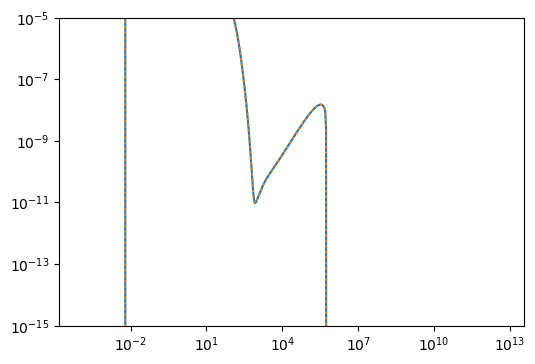

In [31]:
plt.plot(abscs['photE'], soln_0['highengphot'][-1].N)
plt.plot(abscs['photE'], soln_1['highengphot'][-1].N, ':')
plt.plot(abscs['photE'], np.abs(soln_0['highengphot'][-1].N-soln_1['highengphot'][-1].N))
plt.loglog()
plt.ylim(1e-15, 1e-5)

## xHII, xHeII, Tm

In [8]:
soln_0 = pickle.load(open(SOLN_DIR+'E8phc12_ctf.p', 'rb'))
soln_0['label'] = 'CTF'
soln_1 = pickle.load(open(SOLN_DIR+'E8phc12_nnctf_E.p', 'rb'))
soln_1['label'] = 'NN'

In [9]:
textstr =  '$\chi \\to e^+e^-$, $m_\chi = 100$ MeV\n'
textstr += '$\\tau = 3 \\times 10^{25}$s'
#textstr += '\nwith reionization\n backreaction'

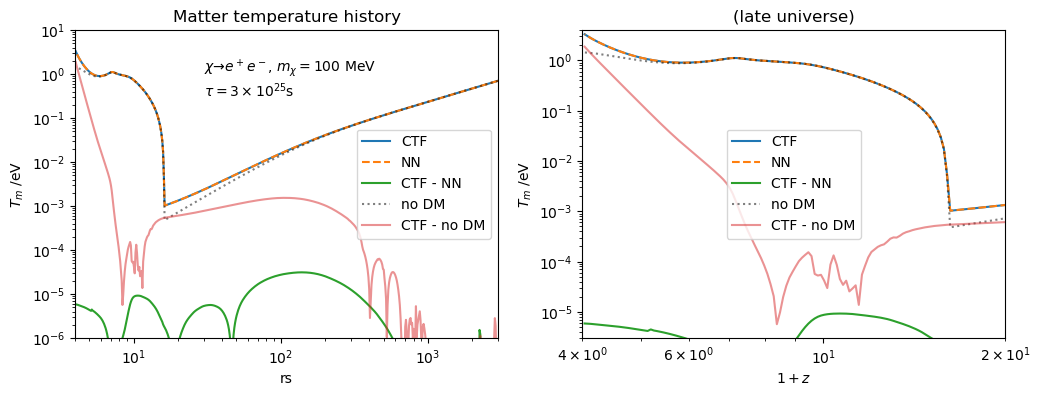

In [18]:
soln_default_reion = tla.get_history(soln_0['rs'], helium_TLA=True, reion_switch=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(soln_0['rs'], soln_0['Tm'], label=soln_0['label'])
axs[0].plot(soln_1['rs'], soln_1['Tm'], '--', label=soln_1['label'])
axs[0].plot(soln_1['rs'], np.abs(soln_0['Tm']-soln_1['Tm']), label='CTF - NN')
axs[0].plot(soln_1['rs'], soln_default_reion[:,0], 'k:', label='no DM', alpha=0.5)
axs[0].plot(soln_1['rs'], np.abs(soln_0['Tm']-soln_default_reion[:,0]), label='CTF - no DM', alpha=0.5)
axs[0].text(30, 0.3, textstr)
axs[0].set(title='Matter temperature history', xlabel='rs', ylabel='$T_m$ /eV')
axs[0].set(xscale='log', xlim=(4,3000))
axs[0].set(yscale='log', ylim=(1e-6,10))
axs[0].legend()

axs[1].plot(soln_0['rs'], soln_0['Tm'], label=soln_0['label'])
axs[1].plot(soln_1['rs'], soln_1['Tm'], '--', label=soln_1['label'])
axs[1].plot(soln_1['rs'], np.abs(soln_0['Tm']-soln_1['Tm']), label='CTF - NN')
axs[1].plot(soln_1['rs'], soln_default_reion[:,0], 'k:', label='no DM', alpha=0.5)
axs[1].plot(soln_1['rs'], np.abs(soln_0['Tm']-soln_default_reion[:,0]), label='CTF - no DM', alpha=0.5)
axs[1].set(title='(late universe)', xlabel='$1+z$', ylabel='$T_m$ /eV')
axs[1].set(xscale='log', xlim=(4, 20))
axs[1].set(yscale='log', ylim=(1e-6,10))
axs[1].set(ylim=(3e-6, 4), yscale='log')
axs[1].legend()
plt.show()
#plt.savefig('Tm.pdf')

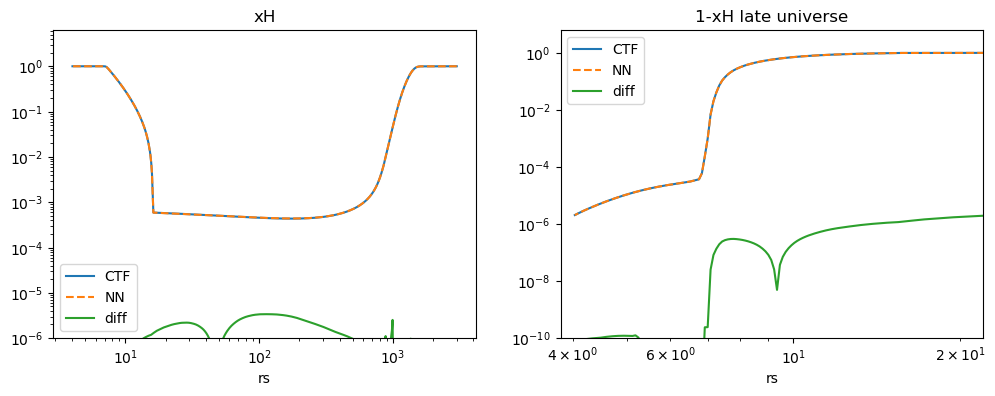

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(soln_0['rs'], soln_0['x'][:,0], label=soln_0['label'])
axs[0].plot(soln_1['rs'], soln_1['x'][:,0], '--', label=soln_1['label'])
axs[0].plot(soln_1['rs'], np.abs(soln_0['x'][:,0]-soln_1['x'][:,0]), label='diff')
axs[0].set(title='xH', xlabel='rs', ylabel='')
axs[0].set(xscale='log')
axs[0].set(ylim=(1e-6, None), yscale='log')
axs[0].legend()

axs[1].plot(soln_0['rs'], 1-soln_0['x'][:,0], label=soln_0['label'])
axs[1].plot(soln_1['rs'], 1-soln_1['x'][:,0], '--', label=soln_1['label'])
axs[1].plot(soln_1['rs'], np.abs(soln_0['x'][:,0]-soln_1['x'][:,0]), label='diff')
axs[1].set(title='1-xH late universe', xlabel='rs', ylabel='')
axs[1].set(xlim=(3.8, 22), xscale='log')
axs[1].set(ylim=(1e-10, None), yscale='log')
axs[1].legend()
plt.show()

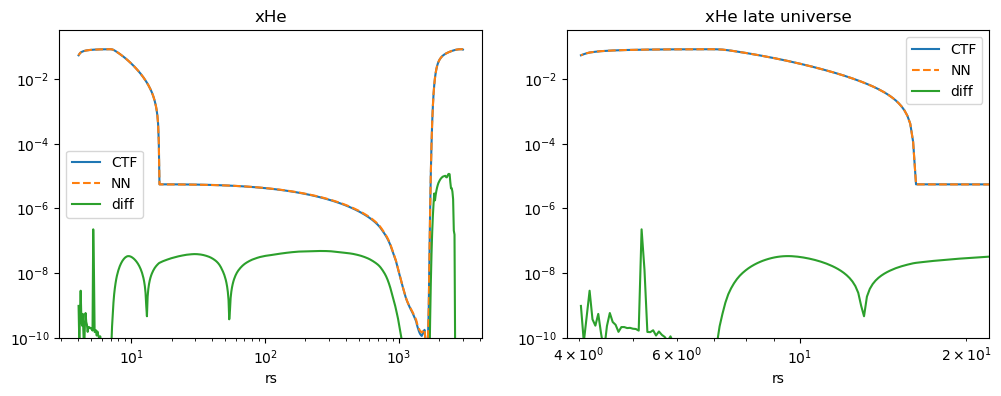

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(soln_0['rs'], soln_0['x'][:,1], label=soln_0['label'])
axs[0].plot(soln_1['rs'], soln_1['x'][:,1], '--', label=soln_1['label'])
axs[0].plot(soln_1['rs'], np.abs(soln_0['x'][:,1]-soln_1['x'][:,1]), label='diff')
axs[0].set(title='xHe', xlabel='rs', ylabel='')
axs[0].set(xscale='log')
axs[0].set(ylim=(1e-10, None), yscale='log')
axs[0].legend()

axs[1].plot(soln_0['rs'], soln_0['x'][:,1], label=soln_0['label'])
axs[1].plot(soln_1['rs'], soln_1['x'][:,1], '--', label=soln_1['label'])
axs[1].plot(soln_1['rs'], np.abs(soln_0['x'][:,1]-soln_1['x'][:,1]), label='diff')
axs[1].set(title='xHe late universe', xlabel='rs', ylabel='')
axs[1].set(xlim=(3.8, 22), xscale='log')
axs[1].set(ylim=(1e-10, None), yscale='log')
axs[1].legend()
plt.show()

## Spectrum

In [31]:
soln_0 = pickle.load(open(SOLN_DIR+'E8phc12_ctf.p', 'rb'))
soln_1 = pickle.load(open(SOLN_DIR+'E8phc12_nnctf_E.p', 'rb'))
#soln_1 = pickle.load(open('soln_c1_NN_test.p', 'rb'))

L1: 0.0565
L2: 0.4221


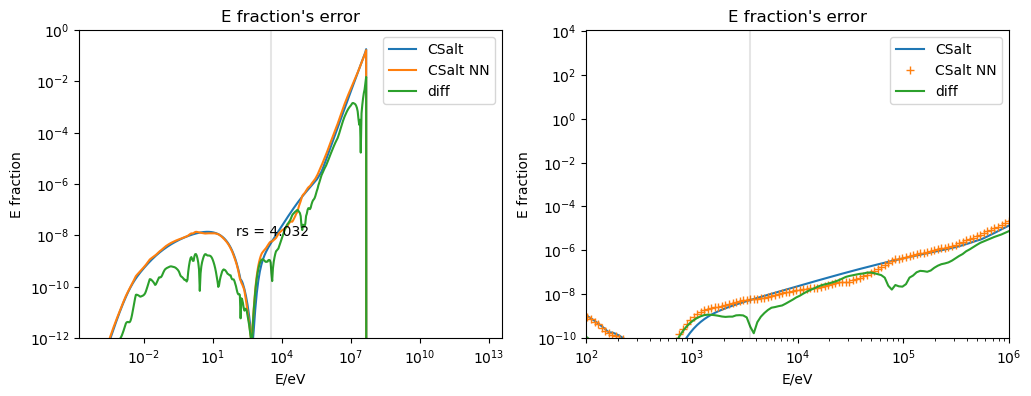

In [23]:
i=-1
collection = 'highengphot'
specs_0 = soln_0[collection]
specs_1 = soln_1[collection]
print( 'L1: %.4f' % ( dL1(E(specs_0[i])-E(specs_1[i]))/specs_0[i].toteng() ) )
print( 'L2: %.4f' % ( dL2(E(specs_0[i])-E(specs_1[i]))/specs_0[i].toteng() ) )

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(specs_0[-1].eng, E(specs_0[i])/ specs_0[i].toteng(), label='CSalt')
axs[0].plot(specs_0[-1].eng, E(specs_1[i])/ specs_0[i].toteng(), label='CSalt NN')
axs[0].plot(specs_0[-1].eng, np.abs(E(specs_1[i])-E(specs_0[i]))/ specs_0[i].toteng(), label='diff')
axs[0].axvline(x=abscs['photE'][225], color='k', alpha=0.1)
axs[0].text(1e2, 1e-8, 'rs = %.3f' % soln_0['rs'][i])
axs[0].loglog()
axs[0].set(title='E fraction\'s error', xlabel='E/eV', ylabel='E fraction')
axs[0].set(ylim=(1e-12, 1))
axs[0].legend()

axs[1].plot(specs_0[-1].eng, E(specs_0[i])/ specs_0[i].toteng(), label='CSalt')
axs[1].plot(specs_0[-1].eng, E(specs_1[i])/ specs_0[i].toteng(), '+', label='CSalt NN')
axs[1].plot(specs_0[-1].eng, np.abs(E(specs_1[i])-E(specs_0[i]))/ specs_0[i].toteng(), label='diff')
axs[1].axvline(x=abscs['photE'][225], color='k', alpha=0.1)
axs[1].loglog()
axs[1].set(title='E fraction\'s error', xlabel='E/eV', ylabel='E fraction')
axs[1].set(ylim=(1e-10, None))
axs[1].set(xlim=(1e2, 1e6))
axs[1].legend()
plt.show()

L1: 0.0606
L2: 0.1617


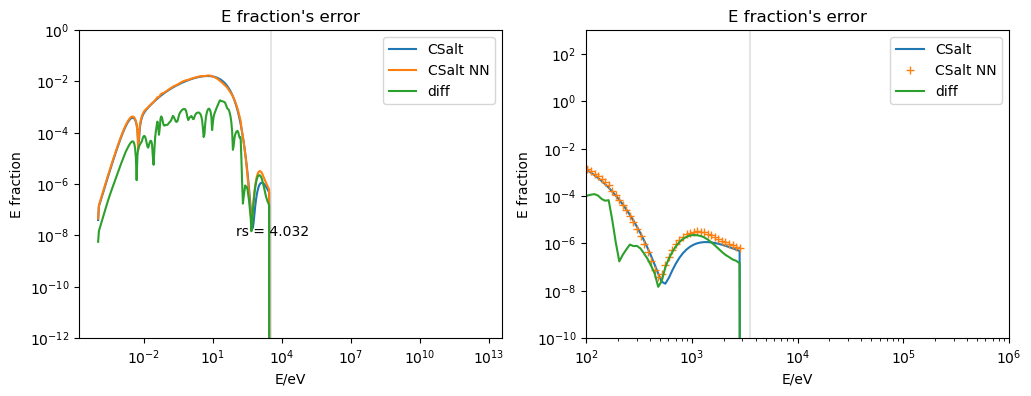

In [24]:
i=-1
collection = 'lowengphot'
specs_0 = soln_0[collection]
specs_1 = soln_1[collection]
print( 'L1: %.4f' % ( dL1(E(specs_0[i])-E(specs_1[i]))/specs_0[i].toteng() ) )
print( 'L2: %.4f' % ( dL2(E(specs_0[i])-E(specs_1[i]))/specs_0[i].toteng() ) )

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(specs_0[-1].eng, np.abs(E(specs_0[i])/ specs_0[i].toteng()), label='CSalt')
axs[0].plot(specs_0[-1].eng, np.abs(E(specs_1[i])/ specs_0[i].toteng()), label='CSalt NN')
axs[0].plot(specs_0[-1].eng, np.abs(E(specs_1[i])-E(specs_0[i]))/ specs_0[i].toteng(), label='diff')
#axs[0].axvline(x=abscs['photE'][225], color='k', alpha=0.1)
axs[0].text(1e2, 1e-8, 'rs = %.3f' % soln_0['rs'][i])
axs[0].loglog()
axs[0].set(title='E fraction\'s error', xlabel='E/eV', ylabel='E fraction')
axs[0].set(ylim=(1e-12, 1))
axs[0].legend()

axs[1].plot(specs_0[-1].eng, E(specs_0[i])/ specs_0[i].toteng(), label='CSalt')
axs[1].plot(specs_0[-1].eng, E(specs_1[i])/ specs_0[i].toteng(), '+', label='CSalt NN')
axs[1].plot(specs_0[-1].eng, np.abs(E(specs_1[i])-E(specs_0[i]))/ specs_0[i].toteng(), label='diff')
#axs[1].axvline(x=abscs['photE'][225], color='k', alpha=0.1)
axs[1].loglog()
axs[1].set(title='E fraction\'s error', xlabel='E/eV', ylabel='E fraction')
axs[1].set(ylim=(1e-10, None))
axs[1].set(xlim=(1e2, 1e6))
axs[1].legend()
plt.show()

In [25]:
collection = 'lowengphot'
specs_0 = soln_0[collection]
specs_1 = soln_1[collection]
L2_arr = []
for i in range(len(soln_0['rs'])):
    L2_arr.append(dL2(E(specs_0[i])-E(specs_1[i]))/specs_0[i].toteng())

<ipython-input-25-fd58e3c87755>:6: RuntimeWarning: invalid value encountered in double_scalars
  L2_arr.append(dL2(E(specs_0[i])-E(specs_1[i]))/specs_0[i].toteng())


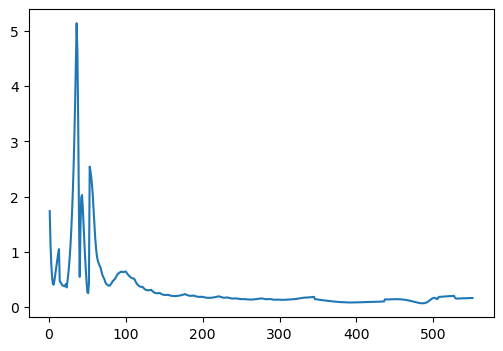

In [26]:
fig, ax = plt.subplots()
#ax.plot(soln_0['rs'], L2_arr)
#ax.set(xlim=(1500,3000), xscale='log')
ax.plot(L2_arr)
#ax.set(xlim=(0,100))
#ax.set(ylim=(0,3))

## Summed spectrum: lowengphot

In [33]:
soln_0 = pickle.load(open(SOLN_DIR+'E8phc12_ctf.p', 'rb'))
soln_0['label'] = 'CTF'
soln_1 = pickle.load(open(SOLN_DIR+'E8phc12_nnctf_E.p', 'rb'))
soln_1['label'] = 'NN'

In [34]:
specs_0 = soln_0['lowengphot']
specs_1 = soln_1['lowengphot']
summed_spec_0 = specs_0[0]*0
summed_spec_1 = specs_1[0]*0
for i in range(len(soln_0['rs'])):
    spec_0 = specs_0[i]*1
    spec_1 = specs_1[i]*1
    spec_0.redshift(1)
    spec_1.redshift(1)
    summed_spec_0 += spec_0
    summed_spec_1 += spec_1

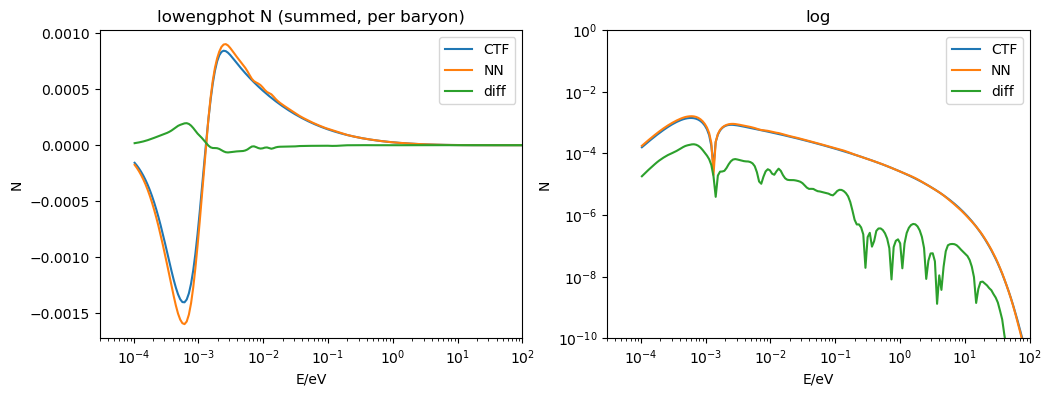

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(abscs['photE'], summed_spec_0.N, label=soln_0['label'])
axs[0].plot(abscs['photE'], summed_spec_1.N, label=soln_1['label'])
axs[0].plot(abscs['photE'], summed_spec_0.N-summed_spec_1.N, label='diff')
axs[0].set(xlim=(3e-5, 1e2))
axs[0].set(xscale='log')
axs[0].set(title='lowengphot N (summed, per baryon)', xlabel='E/eV', ylabel='N')
axs[0].legend()

axs[1].plot(abscs['photE'], np.abs(summed_spec_0.N), label=soln_0['label'])
axs[1].plot(abscs['photE'], np.abs(summed_spec_1.N), label=soln_1['label'])
axs[1].plot(abscs['photE'], np.abs(summed_spec_0.N-summed_spec_1.N), label='diff')
axs[1].set(xlim=(3e-5, 1e2), ylim=(1e-10,1))
axs[1].set(xscale='log', yscale='log')
axs[1].set(title='log', xlabel='E/eV', ylabel='N')
axs[1].legend()

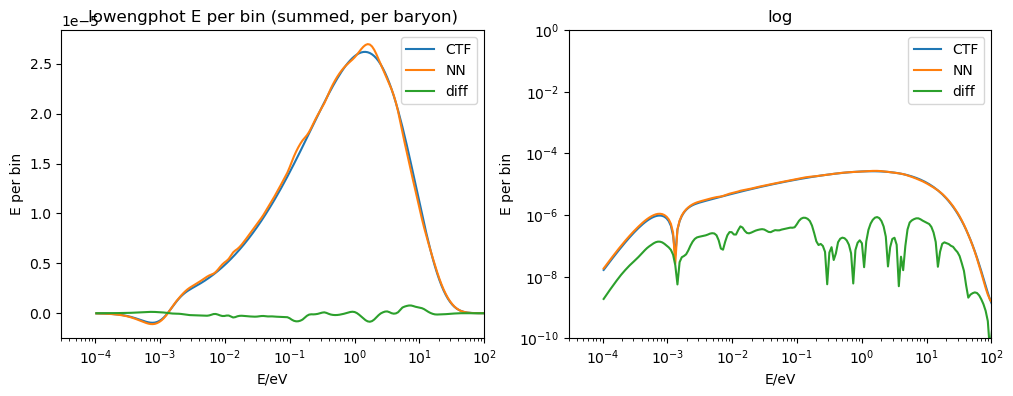

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(abscs['photE'], abscs['photE']*summed_spec_0.N, label=soln_0['label'])
axs[0].plot(abscs['photE'], abscs['photE']*summed_spec_1.N, label=soln_1['label'])
axs[0].plot(abscs['photE'], abscs['photE']*(summed_spec_0.N-summed_spec_1.N), label='diff')
axs[0].set(xlim=(3e-5, 1e2))
axs[0].set(xscale='log')
axs[0].set(title='lowengphot E per bin (summed, per baryon)', xlabel='E/eV', ylabel='E per bin')
axs[0].legend()

axs[1].plot(abscs['photE'], abscs['photE']*np.abs(summed_spec_0.N), label=soln_0['label'])
axs[1].plot(abscs['photE'], abscs['photE']*np.abs(summed_spec_1.N), label=soln_1['label'])
axs[1].plot(abscs['photE'], abscs['photE']*np.abs(summed_spec_0.N-summed_spec_1.N), label='diff')
axs[1].set(xlim=(3e-5, 1e2), ylim=(1e-10,1))
axs[1].set(xscale='log', yscale='log')
axs[1].set(title='log', xlabel='E/eV', ylabel='E per bin')
axs[1].legend()

## Spectrum errors

In [51]:
LEP_err_arr = []
rs_arr = []
collection = 'lowengphot'
specs_0 = soln_0[collection]
specs_1 = soln_1[collection]
spec_tot_0 = specs_0[0]*0
spec_tot_1 = specs_0[0]*0
for i in range(len(specs_0.grid_vals)):
    LEP_err_arr.append(dL2((specs_0[i].N-specs_1[i].N)))
    rs_arr.append(soln_0['rs'][i])

In [42]:
HEP_err_arr = []
rs_arr = []
collection = 'highengphot'
specs_0 = soln_0[collection]
specs_1 = soln_1[collection]
for i in range(len(specs_0.grid_vals)):
    HEP_err_arr.append(dL2((specs_0[i].N-specs_1[i].N)))
    rs_arr.append(soln_0['rs'][i])

Text(0, 0.5, 'L2 error')

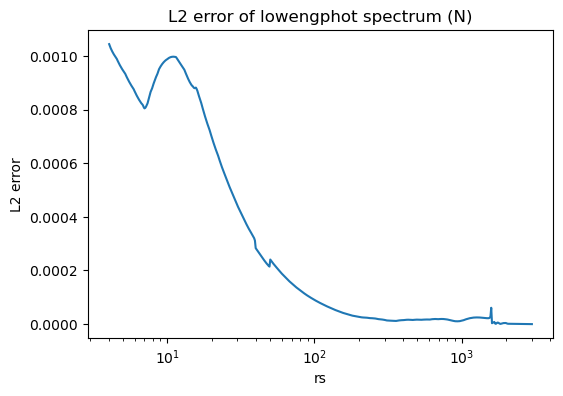

In [52]:
plt.plot(rs_arr, LEP_err_arr)
plt.xscale('log')
plt.title('L2 error of lowengphot spectrum (N)')
plt.xlabel('rs')
plt.ylabel('L2 error')

Text(0, 0.5, 'L2 error')

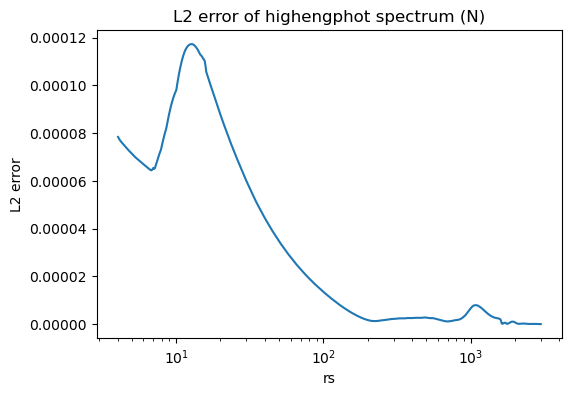

In [44]:
plt.plot(rs_arr, HEP_err_arr)
plt.xscale('log')
plt.title('L2 error of highengphot spectrum (N)')
plt.xlabel('rs')
plt.ylabel('L2 error')